In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import random

In [39]:
DATASET_DIR = r"D:\data0\lsun\bedroom"
EPOCHS = 5
NOISE_LEVEL = 0.3

In [40]:
# Setting a seed for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [41]:
# Define the data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizing to [-1, 1]
])

# Load the dataset using ImageFolder
dataset = datasets.ImageFolder(root=DATASET_DIR, transform=transform)

# Take 50% of the dataset
total_len = len(dataset)
final_subset_indices = np.random.choice(total_len, int(0.5 * total_len), replace=False)

# Create the final subset dataset
subset_dataset = Subset(dataset, final_subset_indices)
dataloader = DataLoader(subset_dataset, batch_size=32, shuffle=True)

In [42]:
# Define a simple diffusion model
class DiffusionModel(nn.Module):
    def __init__(self):
        super(DiffusionModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the model, loss function, and optimizer
model = DiffusionModel().cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
# Training loop
for epoch in range(EPOCHS):
    image_count = 0
    total_images = len(dataloader.dataset)
    for images, _ in dataloader:
        images = images.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

        image_count += images.size(0)
        if image_count % 100 == 0 or image_count == total_images:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Processed {image_count} / {total_images} images, Loss: {loss.item():.4f}')

    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

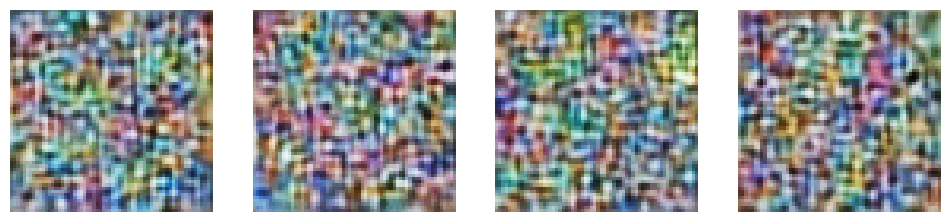

In [ ]:
# Image generation (sampling from the diffusion model)
model.eval()
with torch.no_grad():
    noise = torch.randn((16, 3, 64, 64)).cuda()  # Generate random noise
    generated_images = model(noise).cpu()

# Save or display generated images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, ax in enumerate(axes):
    ax.imshow((generated_images[i].permute(1, 2, 0) + 1) / 2)  # Rescale [-1, 1] to [0, 1]
    ax.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


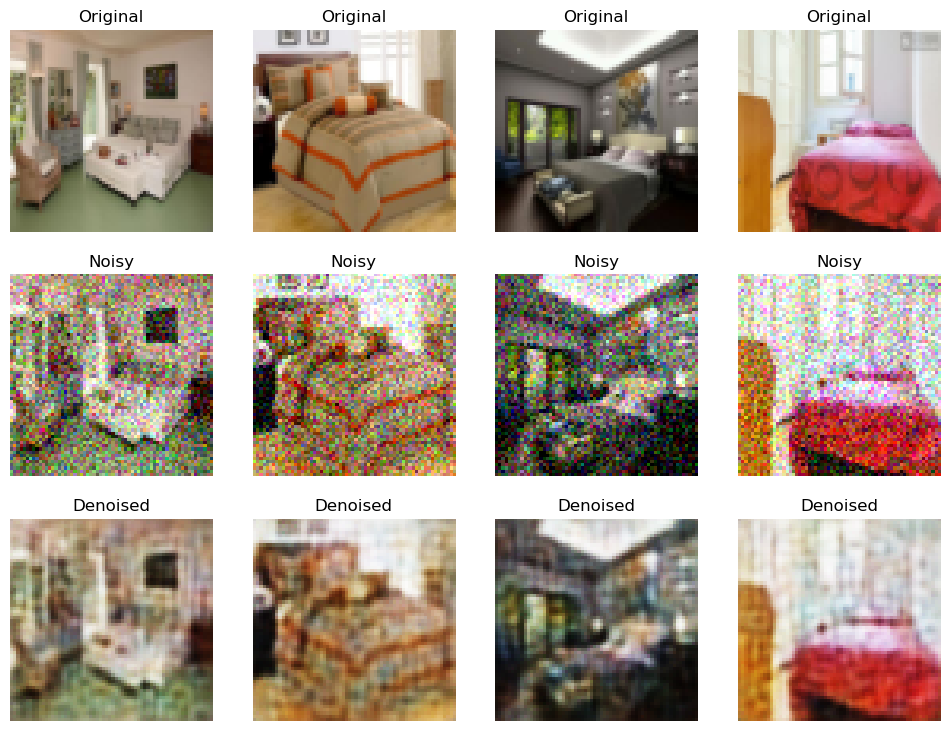

In [ ]:
with torch.no_grad():
    # Load a batch of images from the dataset
    test_loader = DataLoader(subset_dataset, batch_size=16, shuffle=True)
    test_images, _ = next(iter(test_loader))
    test_images = test_images.cuda()

    # Add noise to these images
    noise_level = NOISE_LEVEL  # Adjust the noise level as needed
    noisy_images = test_images + noise_level * torch.randn_like(test_images).cuda()

    # Use the model to denoise the images
    denoised_images = model(noisy_images).cpu()

# Display original, noisy, and denoised images
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 4, figsize=(12, 9))
for i in range(4):
    axes[0, i].imshow((test_images[i].permute(1, 2, 0).cpu() + 1) / 2)
    axes[0, i].set_title('Original')
    axes[0, i].axis('off')
    
    axes[1, i].imshow((noisy_images[i].permute(1, 2, 0).cpu() + 1) / 2)
    axes[1, i].set_title('Noisy')
    axes[1, i].axis('off')
    
    axes[2, i].imshow((denoised_images[i].permute(1, 2, 0) + 1) / 2)
    axes[2, i].set_title('Denoised')
    axes[2, i].axis('off')

plt.show()